## Report

We perform classification of the data using Decision Tree. In the first case, we split the tree using Cross-Entropy and in the second case, we split it using Gini Index. 

Alogrithm:

1. From all attributes list, find the node with minimum Cross-Entropy/Gini-Index
2. Split the data into values from this attribute
3. Assign the node from the remaining attributes to each split data by selecting the node with minimum entropy/gini-index for each splitted data
4. Go to Step 2

I performed a BFS of the tree and calculated the accuracy at each level of the tree. There are [0,1,2] levels in the tree and the accuracy is reported on levels 1 and 2. 

The tree calculated from Gini-Index is same as tree calculated from Cross-Entropy. The values of Gini-Index at each node is less that from the corresponding Cross-Entropy.

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('hw2_question1.csv', \
    names = ["Clump Thickness", "Uniformity of Cell Size", 
             "Uniformity of Cell Shape", "Marginal Adhesion",
            "Single Epithelial Cell Size", "Bare Nuclei",
            "Bland Chromatin", "Normal Nucleoli:",
            "Mitoses", "Class"])

In [3]:
data.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli:,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [288]:
data['Class'].value_counts()

2    444
4    239
dtype: int64

There are 444 samples of class 2 and 239 samples of class 4

### Dividing the data set into training and test set with equal proportions of both the classes

In [6]:
#Dividing the data set into training and test set with equal proportions of both the classes

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33, \
                               stratify=data[['Class']])
print len(train), len(test)

457 226


In [298]:
train['Class'].value_counts()

2    297
4    160
dtype: int64

In [299]:
test['Class'].value_counts()

2    147
4     79
dtype: int64

##### Ratio of both classes in test and train datasets

In [31]:
ratio_train = 297.0/160
print "Ratio of classes in train dataset: ", ratio_train

ratio_test = 147.0/79
print "Ratio of classes in test dataset: ", ratio_test

Ratio of classes in train dataset:  1.85625
Ratio of classes in test dataset:  1.86075949367


In [301]:
train.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli:,Mitoses,Class
217,7,5,6,3,3,8,7,4,1,4
183,1,2,3,1,2,1,3,1,1,2
220,10,5,7,4,4,10,8,9,1,4
44,3,7,7,4,4,9,4,8,1,4
672,4,1,1,1,2,1,1,1,1,2


In [39]:
import collections
d = train.groupby(["Uniformity of Cell Size", "Class"]).size().to_dict()
hashmap = collections.defaultdict(lambda: [0,0])
for key in d:
    if key[1] == 2:
        hashmap[key[0]][0] = d[key]
    if key[1] == 4:
        hashmap[key[0]][1] = d[key]
hashmap

defaultdict(<function __main__.<lambda>>,
            {1: [246, 1],
             2: [26, 5],
             3: [18, 19],
             4: [5, 23],
             5: [0, 15],
             6: [0, 22],
             7: [1, 13],
             8: [1, 16],
             9: [0, 4],
             10: [0, 42]})

## Decision Tree using Entropy Calculation

##### Function to calculate Entropy

In [40]:
#Step 1 - Calculate Entropy
import collections
import math
def calculate_entropy(attribute, data):
    entropy = 0.0
    d = data.groupby([attribute, "Class"]).size().to_dict()
    hashmap = collections.defaultdict(lambda: [0,0])
    for key in d:
        if key[1] == 2:
            hashmap[key[0]][0] = d[key]
        if key[1] == 4:
            hashmap[key[0]][1] = d[key]
    total = sum([sum(x) for x in hashmap.values()])
    for key in hashmap:
        entropy_branch = 0.0
        if hashmap[key][0] != 0.0:
            try:
                entropy_branch += float(hashmap[key][0])\
                /(sum(hashmap[key])) * \
                np.log2(float(hashmap[key][0])\
                        /(sum(hashmap[key])))
            except:
                entropy_branch += 0.0
        if hashmap[key][1] != 0.0:
            try:
                entropy_branch += float(hashmap[key][1])\
                /(sum(hashmap[key])) * \
                np.log2(float(hashmap[key][1])\
                        /(sum(hashmap[key])))
            except:
                entropy_branch += 0.0
        entropy += sum(hashmap[key]) * (-entropy_branch)/total 
    return entropy



##### Here, we calculate the first node to split on

In [41]:
attribute_list = list(train)[:-1]
attribute_list
minimum_entropy = calculate_entropy(attribute_list[0], train)
for attribute in attribute_list:
    if calculate_entropy(attribute, train) < minimum_entropy:
        minimum_entropy = calculate_entropy(attribute, train)
        minimum_attribute = attribute
print "First node to split on: ", minimum_attribute

attribute_list.remove(minimum_attribute)

First node to split on:  Uniformity of Cell Size


##### Function to store all the split values  and  the row indices containing the data on a particular node

In [42]:
def entropy_branch_calculation(attribute, data, parent_value):
    entropy_branch_dict = {}
    value_list = data[attribute].unique().tolist()
    d = data.groupby([attribute, "Class"]).size().to_dict()
    hashmap = collections.defaultdict(lambda: [0,0])
    for key in d:
        if key[1] == 2:
            hashmap[key[0]][0] = d[key]
        if key[1] == 4:
            hashmap[key[0]][1] = d[key]
    for key in hashmap:
        entropy_branch = 0.0
        if hashmap[key][0] != 0.0:
            try:
                entropy_branch += float(hashmap[key][0])\
                /(sum(hashmap[key])) * \
                np.log2(float(hashmap[key][0])\
                        /(sum(hashmap[key])))
            except:
                entropy_branch += 0.0
        if hashmap[key][1] != 0.0:
            try:
                entropy_branch += float(hashmap[key][1])\
                /(sum(hashmap[key])) * \
                np.log2(float(hashmap[key][1])\
                        /(sum(hashmap[key])))
            except:
                entropy_branch += 0.0
        class_predicted = '2' if hashmap[key][0] > hashmap[key][1] else '4'
        if entropy_branch != 0:
            entropy_branch_dict\
            [(parent_value, attribute, key, class_predicted)] \
            = (data[(data[attribute]  == key)].index.tolist())
    return entropy_branch_dict
entropy_branch =  entropy_branch_calculation\
(minimum_attribute, train, None)


#### Build the Tree. I am performing a Breadth First Traversal of the tree structure and each node stores the following value: (Parent's  value, Current Attribute, Current Attribute Value, Child Attribute, Class Predicted ). The output we see below is the tree structure. 

In [43]:
#Step 2 - make a decision tree and perform split


level = collections.defaultdict(list)
level[0].append((None, None, None, minimum_attribute, None))
queue = []
count_level = 0
queue.append((count_level, entropy_branch))
# print queue
count_level += 1
while len(attribute_list) > 0 and len(queue) > 0:
    for node in queue:
        level_order_queue = []
        for key in node[1]:
            data = train.loc[node[1][key]]
            minimum_entropy = calculate_entropy(attribute_list[0], data)
            minimum_attribute = attribute_list[0]
            for attribute in attribute_list:
                entropy = calculate_entropy(attribute, data)
                if entropy < minimum_entropy:
                    minimum_entropy = entropy
                    minimum_attribute = attribute
            level[count_level].append((key[0], key[1], key[2], \
                                       minimum_attribute, key[3]))
            entropy_branch_node = entropy_branch_calculation\
            (minimum_attribute, data, key[2])
            level_order_queue.append(entropy_branch_node)
        queue.pop(0)
        if len(queue) == 0:
            for node_level_order in level_order_queue:
                queue.append((count_level, node_level_order))
            attribute_list_level = []
            for attribute_level in level[count_level]:
                attribute_list_level.append(attribute_level[3])
            for attribute in set(attribute_list_level):
                attribute_list.remove(attribute)
            count_level += 1
print level
            
    





defaultdict(<type 'list'>, {0: [(None, None, None, 'Uniformity of Cell Size', None)], 1: [(None, 'Uniformity of Cell Size', 8, 'Marginal Adhesion', '4'), (None, 'Uniformity of Cell Size', 1, 'Clump Thickness', '2'), (None, 'Uniformity of Cell Size', 4, 'Clump Thickness', '4'), (None, 'Uniformity of Cell Size', 7, 'Bare Nuclei', '4'), (None, 'Uniformity of Cell Size', 2, 'Bare Nuclei', '2'), (None, 'Uniformity of Cell Size', 3, 'Bare Nuclei', '4')], 2: [(3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4')], 3: []})


## Tree Structure using Cross Entropy: 

defaultdict(<type 'list'>, {0: [(None, None, None, 'Uniformity of Cell Size', None)], 1: [(None, 'Uniformity of Cell Size', 8, 'Marginal Adhesion', '4'), (None, 'Uniformity of Cell Size', 1, 'Clump Thickness', '2'), (None, 'Uniformity of Cell Size', 4, 'Clump Thickness', '4'), (None, 'Uniformity of Cell Size', 7, 'Bare Nuclei', '4'), (None, 'Uniformity of Cell Size', 2, 'Bare Nuclei', '2'), (None, 'Uniformity of Cell Size', 3, 'Bare Nuclei', '4')], 2: [(3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4')], 3: []})


#### Calculating Training Accuracy - I am calculating the accuracy for each level of the tree after all the nodes at a certain level have been added. My tree has 2 levels and I am calculating the accuracy at 1st and 2nd level of tree

In [36]:
#calculating training accuracy

correctly_classified_level_1 = 0
feature_values = range(1,11)
for data in level[1]:
    if data[4] == '2':
        correctly_classified_level_1 += hashmap[data[2]][0]
        
    else:
        correctly_classified_level_1 += hashmap[data[2]][1]
    feature_values.remove(data[2])
        
for val in feature_values:
    correctly_classified_level_1 += sum(hashmap[val])
print "Accuracy on first level of tree:", \
float(correctly_classified_level_1)/len(train)

bare_nuclei_split_row_indices_2 = \
train[(train['Uniformity of Cell Size']  == 2)]\
.index.tolist()
bare_nuclei_split_row_indices_1 = \
train[(train['Uniformity of Cell Size']  == 1)]\
.index.tolist()
single_epithelial_row_indices_4 = \
train[(train['Uniformity of Cell Size']  == 4)]\
.index.tolist()
bare_nuclei_split_data_2 = train.loc\
[bare_nuclei_split_row_indices_2]
bare_nuclei_split_data_1 = train.loc\
[bare_nuclei_split_row_indices_1]
single_epithelial_split_data_4 = train.loc\
[single_epithelial_row_indices_4]
d1 = bare_nuclei_split_data_2.groupby\
(["Bare Nuclei", "Class"]).size().to_dict()
hashmap1 = collections.defaultdict(lambda: [0,0])
for key in d1:
    if key[1] == 2:
        hashmap1[key[0]][0] = d1[key]
    if key[1] == 4:
        hashmap1[key[0]][1] = d1[key]
d2 = single_epithelial_split_data_4.groupby\
(["Single Epithelial Cell Size", "Class"])\
.size().to_dict()
d3 = bare_nuclei_split_data_1.groupby\
(["Bare Nuclei", "Class"]).size().to_dict()
hashmap2 = collections.defaultdict(lambda: [0,0])
for key in d2:
    if key[1] == 2:
        hashmap2[key[0]][0] = d2[key]
    if key[1] == 4:
        hashmap2[key[0]][1] = d2[key]
correctly_classified_level_2 = 0
feature_values = range(1,11)

bare_nuclei_split_row_indices_3 = \
train[(train['Uniformity of Cell Size']  == 3)]\
.index.tolist()
bare_nuclei_split_data_3 = \
train.loc[bare_nuclei_split_row_indices_3]
d4 = bare_nuclei_split_data_3.\
groupby(["Bare Nuclei", "Class"]).size().to_dict()

clump_thickness_split_row_indices_2 = \
train[(train['Uniformity of Cell Size']  == 2)]\
.index.tolist()
clump_thickness_split_data_2 = \
train.loc[clump_thickness_split_row_indices_2]
d5 = clump_thickness_split_data_2.\
groupby(["Clump Thickness", "Class"]).size().\
to_dict()

correctly_classified_level_2 = (18+246+20+27+13+25+23+16+3+44)
print "Accuracy on 2nd level of tree: ", \
float(correctly_classified_level_2)/len(train)

Accuracy on first level of tree: 0.932166301969
Accuracy on 2nd level of tree:  0.951859956236


##### Calculating Accuracy on test dataset

In [37]:
#calculating testing accuracy

import collections
d = test.groupby(["Uniformity of Cell Size", "Class"])\
.size().to_dict()
hashmap_test = collections.defaultdict(lambda: [0,0])
for key in d:
    if key[1] == 2:
        hashmap_test[key[0]][0] = d[key]
    if key[1] == 4:
        hashmap_test[key[0]][1] = d[key]

correctly_classified_level_1_test = 0
feature_values = range(1,11)
for data in level[1]:
    if data[4] == '2':
        correctly_classified_level_1_test += \
        hashmap_test[data[2]][0]
        
    else:
        correctly_classified_level_1_test += \
        hashmap_test[data[2]][1]
    feature_values.remove(data[2])
        
for val in feature_values:
    correctly_classified_level_1_test += \
    sum(hashmap_test[val])
print "Accuracy on first level of tree: ", \
float(correctly_classified_level_1_test)/len(test)

bare_nuclei_split_row_indices_1 = \
test[(test['Uniformity of Cell Size']  == 1)].\
index.tolist()
bare_nuclei_split_data_1 = \
test.loc[bare_nuclei_split_row_indices_1]
d1 = bare_nuclei_split_data_1.\
groupby(["Bare Nuclei", "Class"]).size().to_dict()


bare_nuclei_split_row_indices_3 = \
test[(test['Uniformity of Cell Size']  == 3)].\
index.tolist()
bare_nuclei_split_data_3 = test.loc[bare_nuclei_split_row_indices_3]
d2 = bare_nuclei_split_data_3.\
groupby(["Bare Nuclei", "Class"]).size().to_dict()

clump_thickness_split_row_indices_2 = \
test[(test['Uniformity of Cell Size']  == 2)].\
index.tolist()
clump_thickness_split_data_2 = \
test.loc[clump_thickness_split_row_indices_2]
d3 = clump_thickness_split_data_2.\
groupby(["Clump Thickness", "Class"]).size().to_dict()

correctly_classified_level_2_test = \
(9+118+10+17+5+13+7+9+2+23)
print "Accuracy on 2nd level of tree: ", \
float(correctly_classified_level_2_test)/len(test)




Accuracy on first level of tree:  0.920353982301
Accuracy on 2nd level of tree:  0.942477876106


##### Plotting the training accuracy at levels 1 and 2

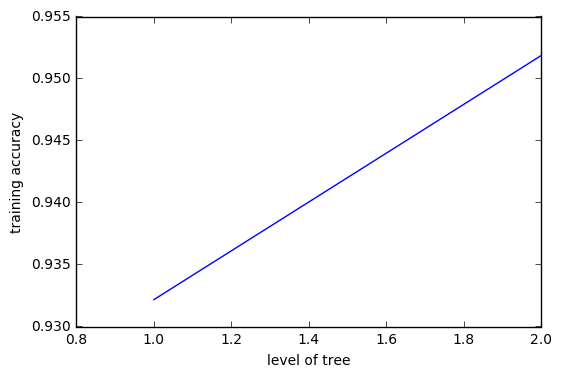

In [19]:
import matplotlib.pyplot as plt
training_accuracy = [0.932166301969, 0.951859956236]


plt.plot([1,2], training_accuracy)
plt.ylabel('training accuracy')
plt.xlabel('level of tree')
plt.show()


##### Plotting testing accuracy on levels 1 and 2

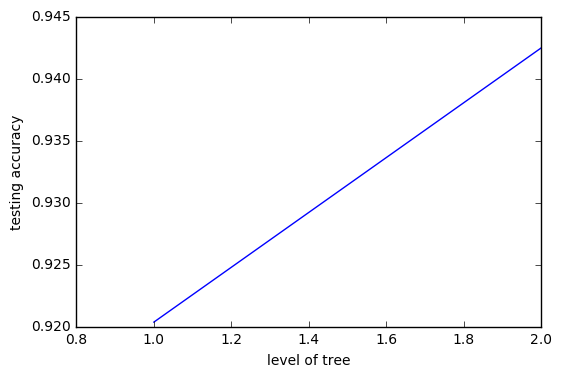

In [20]:
testing_accuracy = [0.920353982301, 0.942477876106]
plt.plot([1,2], testing_accuracy)
plt.ylabel('testing accuracy')
plt.xlabel('level of tree')
plt.show()

## Decision Tree using Gini Index:

In [44]:
#calculating gini index
def calculate_gini_index(attribute, data):
    gini_index = 0.0
    d = data.groupby([attribute, "Class"]).size().to_dict()
    hashmap = collections.defaultdict(lambda: [0,0])
    for key in d:
        if key[1] == 2:
            hashmap[key[0]][0] = d[key]
        if key[1] == 4:
            hashmap[key[0]][1] = d[key]
    total = sum([sum(x) for x in hashmap.values()])
    for key in hashmap:
        gini_index_branch = 0.0
        if hashmap[key][0] != 0.0:
            try:
                gini_index_branch += float(hashmap[key][0])\
                /(sum(hashmap[key])) * \
                (1 - float(hashmap[key][0])/(sum(hashmap[key])))
            except:
                gini_index_branch += 0.0
        if hashmap[key][1] != 0.0:
            try:
                gini_index_branch += float(hashmap[key][1])\
                /(sum(hashmap[key])) * \
                (1 - float(hashmap[key][1])/(sum(hashmap[key])))
            except:
                gini_index_branch += 0.0
        gini_index += sum(hashmap[key]) * (gini_index_branch)/total 
    return gini_index


In [45]:
attribute_list = list(train)[:-1]
minimum_gini_index = calculate_gini_index(attribute_list[0], train)
minimum_attribute_gini_index = attribute_list[0]
for attribute in attribute_list:
    if calculate_gini_index(attribute, train) < minimum_gini_index:
        minimum_gini_index = calculate_gini_index(attribute, train)
        minimum_attribute_gini_index = attribute
print "First node to split on: ", minimum_attribute_gini_index

attribute_list.remove(minimum_attribute_gini_index)

First node to split on:  Uniformity of Cell Size


In [46]:
def gini_index_branch_calculation(attribute, data, parent_value):
    gini_index_branch_dict = {}
    value_list = data[attribute].unique().tolist()
    d = data.groupby([attribute, "Class"]).size().to_dict()
    hashmap = collections.defaultdict(lambda: [0,0])
    for key in d:
        if key[1] == 2:
            hashmap[key[0]][0] = d[key]
        if key[1] == 4:
            hashmap[key[0]][1] = d[key]
    for key in hashmap:
        gini_index_branch = 0.0
        if hashmap[key][0] != 0.0:
            try:
                gini_index_branch += float(hashmap[key][0])\
                /(sum(hashmap[key])) * \
                (1 - float(hashmap[key][0])/(sum(hashmap[key])))
            except:
                gini_index_branch += 0.0
        if hashmap[key][1] != 0.0:
            try:
                gini_index_branch += float(hashmap[key][1])\
                /(sum(hashmap[key])) * \
                (1 - float(hashmap[key][1])/(sum(hashmap[key])))
            except:
                gini_index_branch += 0.0
        class_predicted = '2' if hashmap[key][0] > \
        hashmap[key][1] else '4'
        if gini_index_branch != 0:
            gini_index_branch_dict\
            [(parent_value, attribute, key, class_predicted)]\
            = (data[(data[attribute]  == key)].index.tolist())
    return gini_index_branch_dict
gini_index_branch =  gini_index_branch_calculation\
(minimum_attribute_gini_index, train, None)


In [47]:
#Step 2 - make a decision tree and perform split


level = collections.defaultdict(list)
level[0].append\
((None, None, None, minimum_attribute_gini_index, None))
queue = []
count_level = 0
queue.append((count_level, gini_index_branch))
count_level += 1
while len(attribute_list) > 0 and len(queue) > 0:
    for node in queue:
        level_order_queue = []
        for key in node[1]:
            data = train.loc[node[1][key]]
            minimum_gini_index = \
            calculate_gini_index(attribute_list[0], data)
            minimum_attribute_gini_index = attribute_list[0]
            for attribute in attribute_list:
                gini_index = calculate_gini_index(attribute, data)
                if gini_index < minimum_gini_index:
                    minimum_gini_index = gini_index
                    minimum_attribute_gini_index = attribute
            level[count_level].append\
            ((key[0], key[1], key[2], \
              minimum_attribute_gini_index, key[3]))
            gini_index_branch_node = \
            gini_index_branch_calculation\
            (minimum_attribute_gini_index, data, key[2])
            level_order_queue.append(gini_index_branch_node)
        queue.pop(0)
        if len(queue) == 0:
            for node_level_order in level_order_queue:
                queue.append((count_level, node_level_order))
            attribute_list_level = []
            for attribute_level in level[count_level]:
                attribute_list_level.append(attribute_level[3])
            for attribute in set(attribute_list_level):
                attribute_list.remove(attribute)
            count_level += 1
print level


defaultdict(<type 'list'>, {0: [(None, None, None, 'Uniformity of Cell Size', None)], 1: [(None, 'Uniformity of Cell Size', 8, 'Marginal Adhesion', '4'), (None, 'Uniformity of Cell Size', 1, 'Clump Thickness', '2'), (None, 'Uniformity of Cell Size', 4, 'Clump Thickness', '4'), (None, 'Uniformity of Cell Size', 7, 'Bare Nuclei', '4'), (None, 'Uniformity of Cell Size', 2, 'Bare Nuclei', '2'), (None, 'Uniformity of Cell Size', 3, 'Bare Nuclei', '4')], 2: [(3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4')], 3: []})


## Decision Tree using Gini Index

defaultdict(<type 'list'>, {0: [(None, None, None, 'Uniformity of Cell Size', None)], 1: [(None, 'Uniformity of Cell Size', 8, 'Marginal Adhesion', '4'), (None, 'Uniformity of Cell Size', 1, 'Clump Thickness', '2'), (None, 'Uniformity of Cell Size', 4, 'Clump Thickness', '4'), (None, 'Uniformity of Cell Size', 7, 'Bare Nuclei', '4'), (None, 'Uniformity of Cell Size', 2, 'Bare Nuclei', '2'), (None, 'Uniformity of Cell Size', 3, 'Bare Nuclei', '4')], 2: [(3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4'), (3, 'Bare Nuclei', 2, 'Uniformity of Cell Shape', '2'), (3, 'Bare Nuclei', 3, 'Uniformity of Cell Shape', '4')], 3: []})


##### The decision tree we get from gini index is same as that we get from entropy calculation. So training accuracy and testing accuracy are also same.



#### Plotting training and testing accuracy with Gini Index Calculation

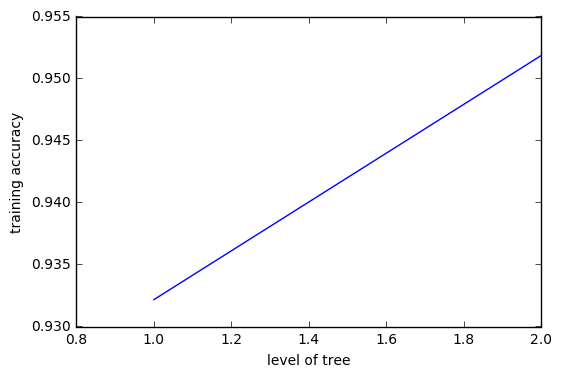

In [29]:
training_accuracy = [0.932166301969, 0.951859956236]


plt.plot([1,2], training_accuracy)
plt.ylabel('training accuracy')
plt.xlabel('level of tree')
plt.show()

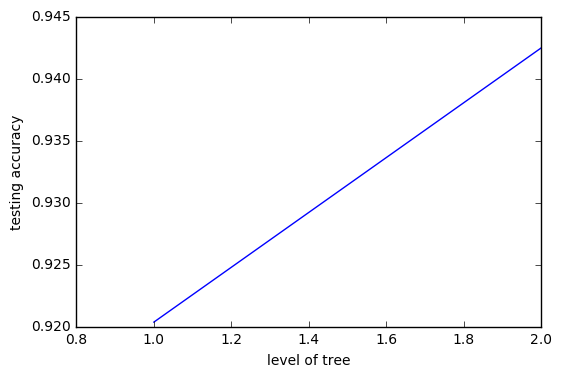

In [30]:
testing_accuracy = [0.920353982301, 0.942477876106]
plt.plot([1,2], testing_accuracy)
plt.ylabel('testing accuracy')
plt.xlabel('level of tree')
plt.show()